In [1]:
import pypsa
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

In [2]:
tech_colors= {
    'onwind': "#235ebc",
    'onshore wind': "#235ebc",
    'offwind': "#6895dd",
    'offshore wind': "#6895dd",
    'offwind-ac': "#6895dd",
    'offshore wind (AC)': "#6895dd",
    'offwind-dc': "#74c6f2",
    'offshore wind (DC)': "#74c6f2",
    'hydro': '#298c81',
    'hydro reservoir': '#298c81',
    'ror': '#3dbfb0',
    'run of river': '#3dbfb0',
    'hydroelectricity': '#298c81',
    'PHS': '#51dbcc',
    'wave': '#a7d4cf',
    'solar': "#f9d002",
    'solar PV': "#f9d002",
    'solar thermal': '#ffbf2b',
    'solar rooftop': 'orange',
    'OCGT': '#e0986c',
    'gas': '#e05b09',
    'fossil gas': '#e05b09',
    'natural gas': '#e05b09',
    'CCGT': '#a85522',
    'Nuclear': '#ff8c00',
    'Nuclear marginal': '#ff8c00',
    'nuclear': 'brown',
    'uranium': '#ff8c00',
    'battery discharger': '#ace37f',
    'battery charger': '#ace37f',
    'home battery charger': 'red',
    'home battery discharger': '#80c944',
    'hydrogen': '#bf13a0',
    'SMR': '#870c71',
    'SMR CC': '#4f1745',
    'H2 Fuel Cell': '#c251ae',
    'H2 Electrolysis': '#ff29d9',
    'electricity distribution grid': 'grey'
}

In [3]:
cmap = {
    "electricity": "Blues",
    "H2": "RdPu",
    "heat": "Reds",
    "solid biomass": "Greens",
    "gas": "Oranges",
    "oil": "Greys",
    "process emission": "Greys",
}
regex = {
    "electricity": r"(electricity|EV)",
    "H2": r"(H2|fuel cell)",
    "heat": r"heat",
    "solid biomass": r"biomass",
    "oil": r"( oil|naphtha|kerosene)",
    "gas": r"gas",
}


INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0p5-2H-solar+p3-dist2_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and w

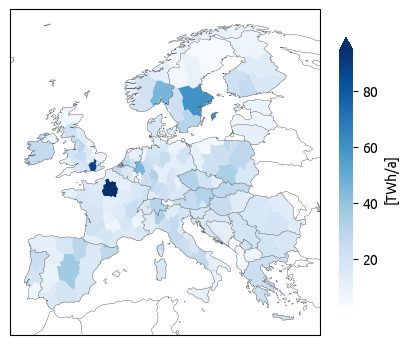

In [4]:
#for 181 nodes
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd

n=pypsa.Network('elec_s_181_lv1.0__Co2L0p5-2H-solar+p3-dist2_2030.nc')

proj = ccrs.EqualEarth()

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": proj})
plt.rcParams['figure.dpi'] = 1000
plt.rc('font',family='Ubuntu')
plt.rc('axes',edgecolor='None')

geodf = gpd.read_file('regions_onshore_elec_s_181.geojson').set_index("name")
from pypsa.descriptors import get_switchable_as_dense as as_dense

demand = as_dense(n, "Load", "p_set").div(1e6)  # TWh
demand_grouped = demand.groupby(
    [n.loads.carrier, n.loads.bus.map(n.buses.location)], axis=1
).sum()
demand_by_region = (n.snapshot_weightings.generators @ demand_grouped).unstack(level=0)  #2 :hourly res , (n.snapshot_weightings.generators @ demand_grouped).unstack(level=0)

geodf = geodf.to_crs(proj.proj4_init)


geodf.plot(
        ax=ax,
        column=2*n.loads_t.p_set.sum()/1e6, #demand_by_region.filter(regex=regex['electricity']).sum(axis=1) ,
        # transform=ccrs.PlateCarree(),
        cmap=cmap['electricity'],
        alpha=1,
        linewidths=0,
        #vmax=60,
        legend=True,
        legend_kwds={"label": '[TWh/a]', "shrink": 0.7, "extend": "max"},  #title['electricity']
        
    )
ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)
plt.show()    

/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


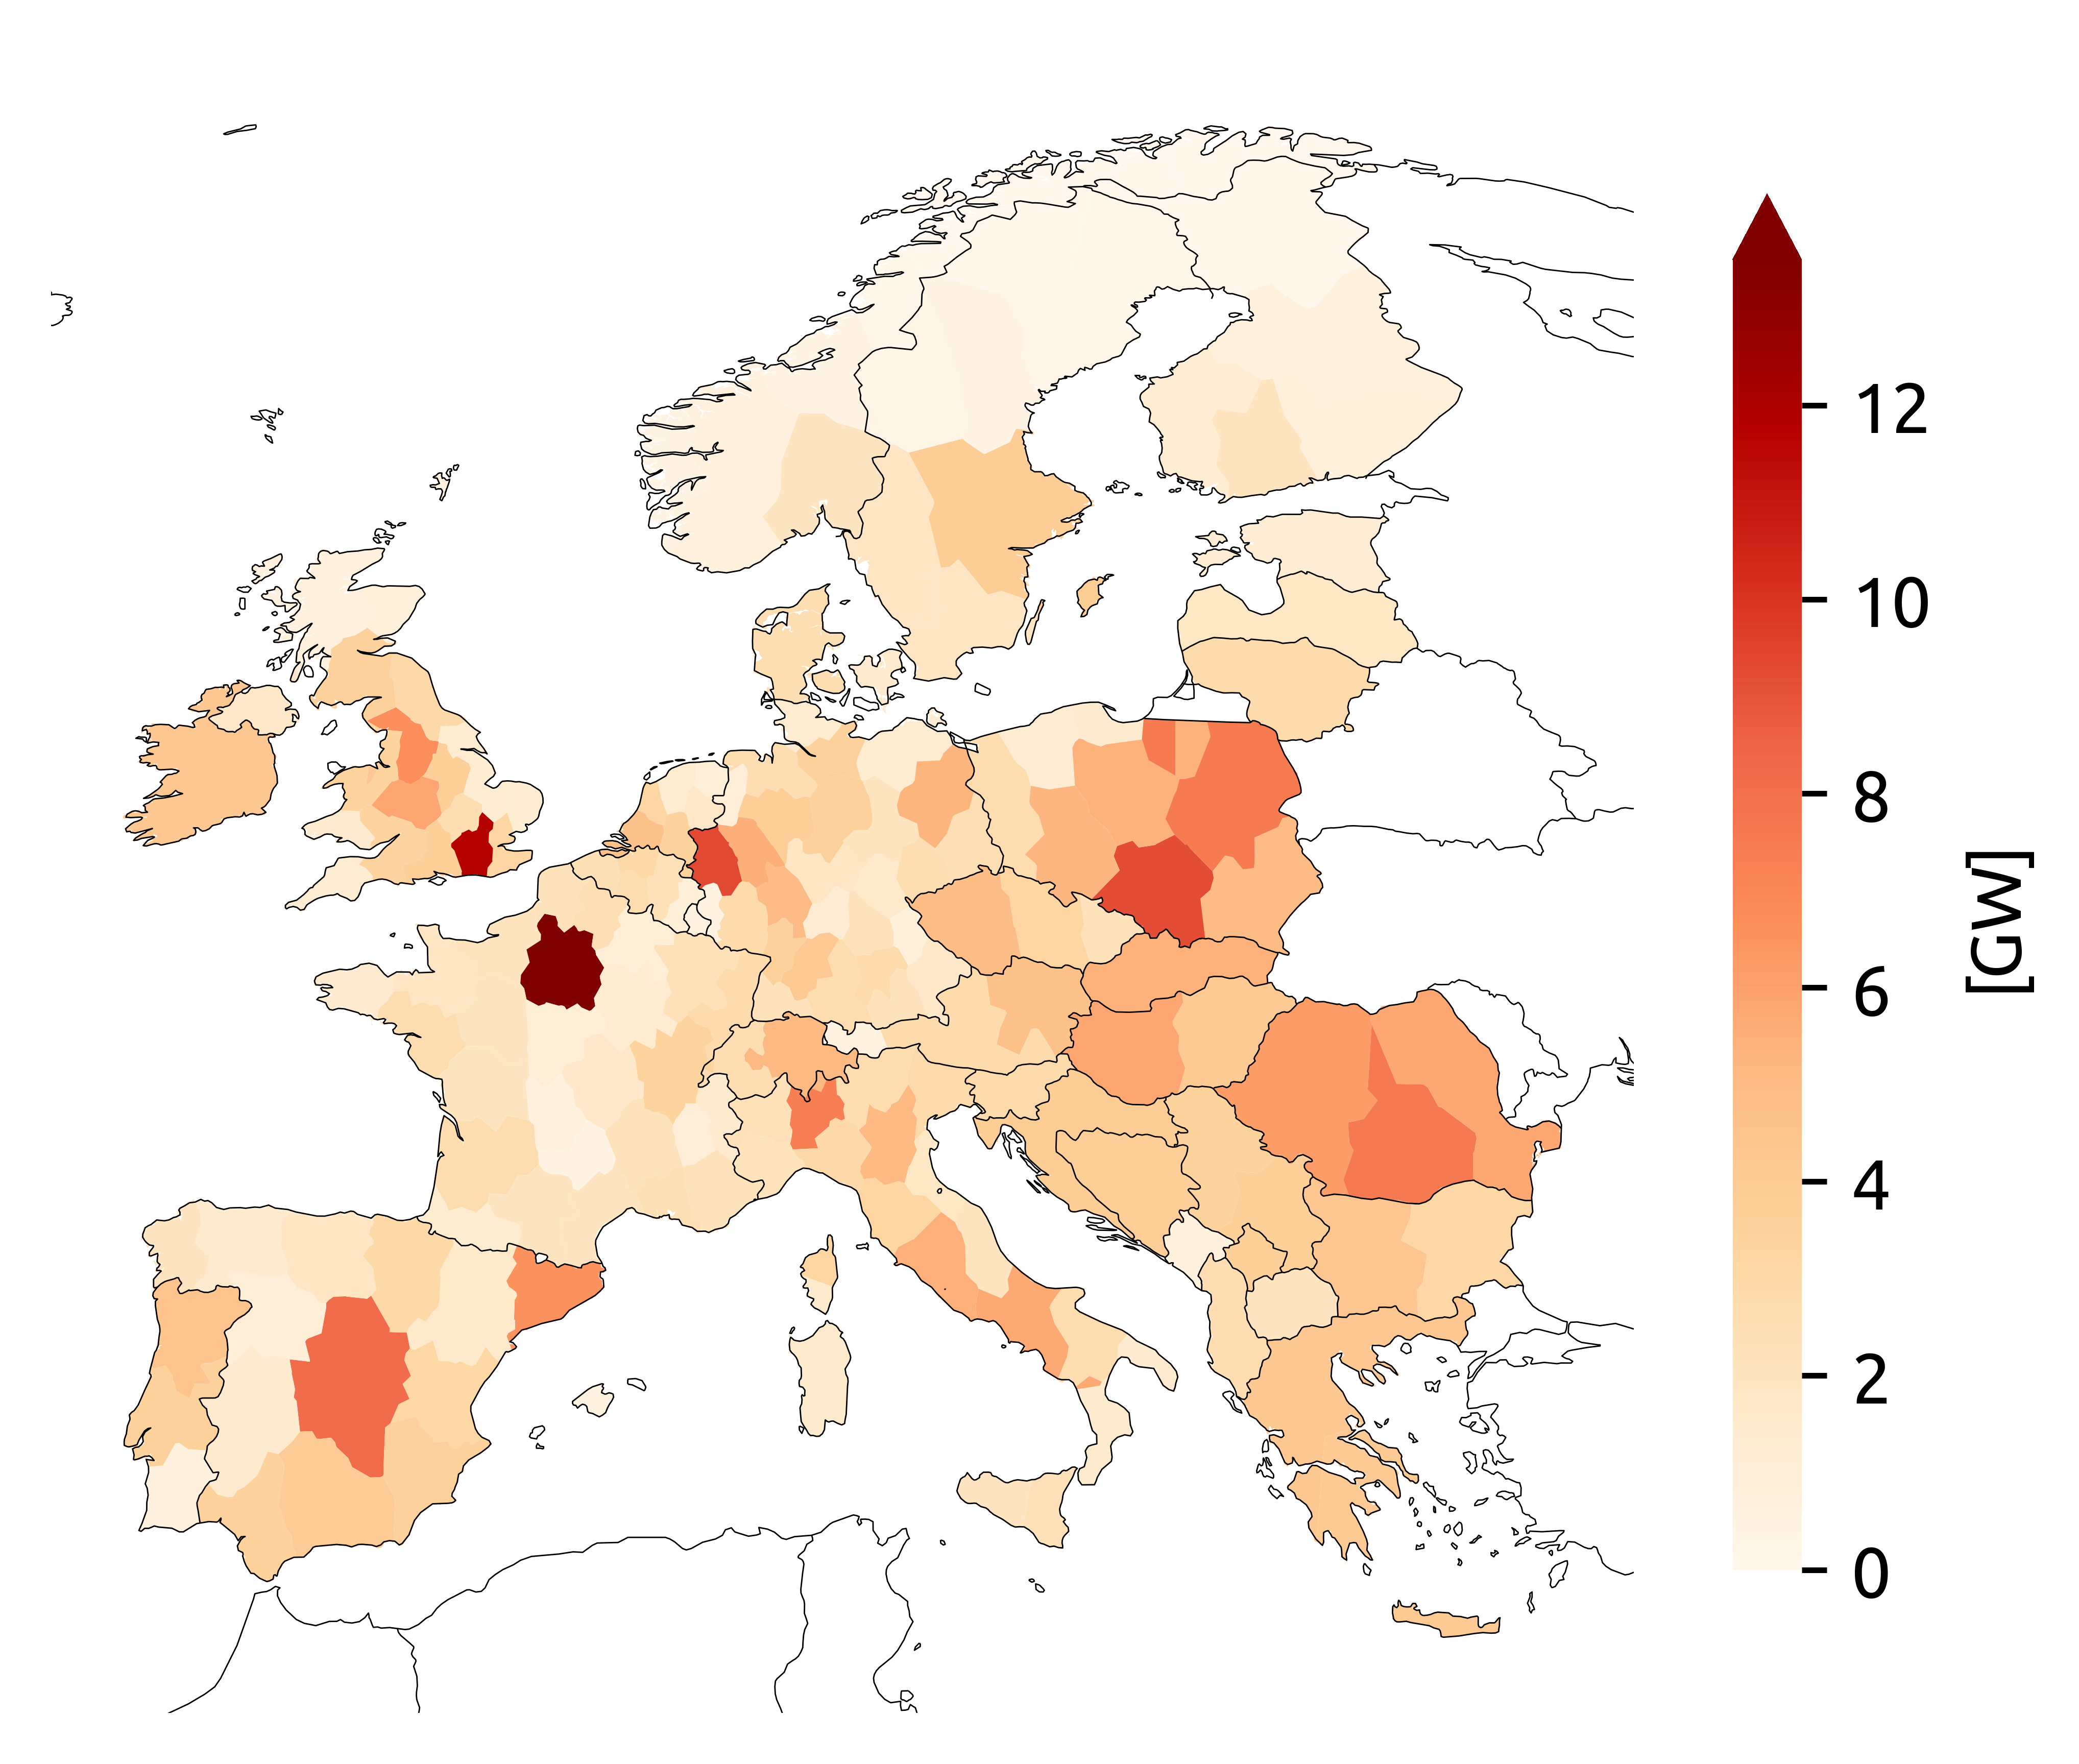

In [5]:
#for 181
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={"projection": proj})

s=(pd.Series((n.generators.p_nom_max.groupby([ n.generators.carrier , n.generators.bus.map(n.buses.location)])
   .sum()['solar rooftop']),geodf.index).fillna(0))


geodf.plot(
        ax=ax,
        column=s/1e3,   #MW to GW
        # transform=ccrs.PlateCarree(),
        cmap="OrRd",
        alpha=1,
        linewidths=0,
        vmax=s.max()/1e3,
        legend=True,
        legend_kwds={"label": '[GW]', "shrink": 0.7, "extend": "max"},  #Solar rooftop max capacity
        
    )

ax.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
ax.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


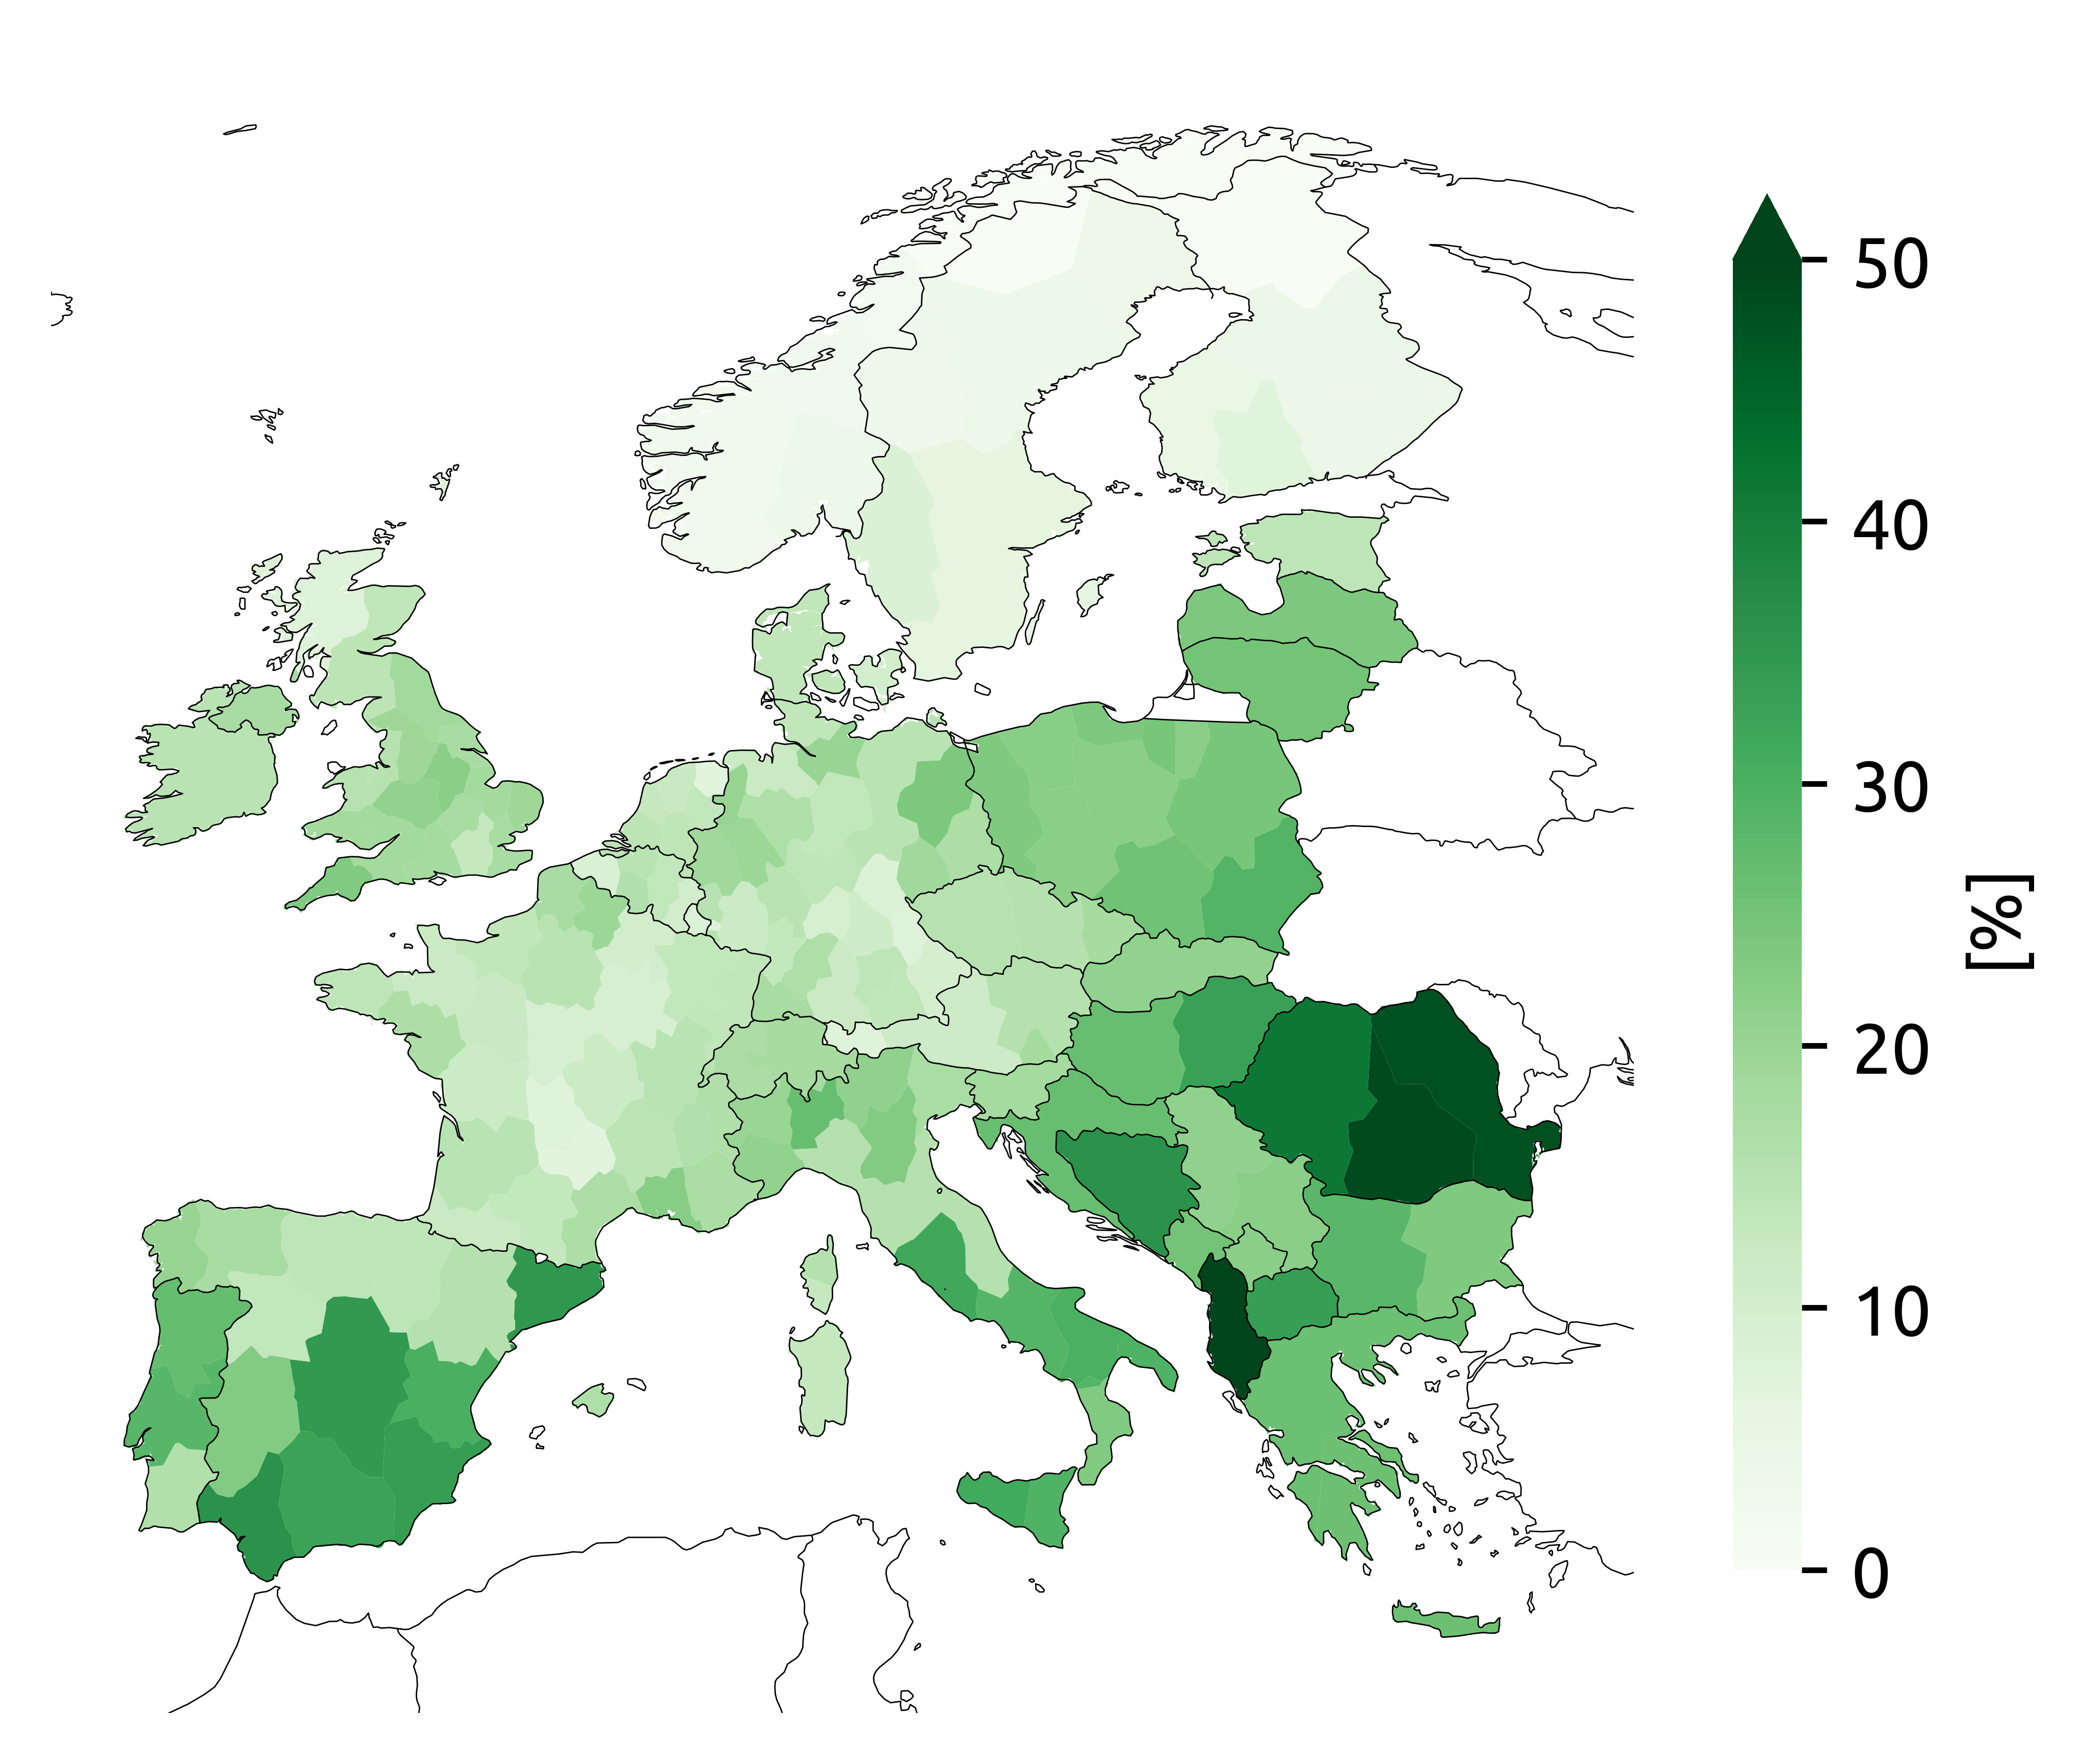

In [6]:
fig, axs = plt.subplots(figsize=(5, 5), subplot_kw={"projection": proj})

s_rooftop=(2*(pd.Series((n.generators_t.p_max_pu.sum().groupby([ n.generators.carrier , n.generators.bus.map(n.buses.location)])
   .sum()['solar rooftop']),geodf.index).fillna(0))*s)  ##max generation

geodf.plot(
        ax=axs,
        column=s_rooftop*100/(2*n.loads_t.p_set.sum()), #(dem*1e6),
        # transform=ccrs.PlateCarree(),
        cmap="Greens",
        alpha=1,
        linewidths=0,
        vmax=50,
        legend=True,
        legend_kwds={"label": '[%]', "shrink": 0.7, "extend": "max"}, #Max. solar roofotp generation\nto total electricity demand 
        
    )
axs.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
axs.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)
    
plt.show()

In [13]:
import pandas as pd
import jenkspy



df=pd.DataFrame({})
dem=demand_by_region.filter(regex=regex['electricity']).sum(axis=1)
df['demand'] = dem

breaks = jenkspy.jenks_breaks(s, n_classes=4)
print(breaks)

df['cut_jenks'] = pd.cut(s,
                        bins=breaks,
                        labels=['0','1', '2','3'])

df['cut_jenksv2'] = pd.cut(s,
                        bins=breaks,
                        labels=['0','1', '2','3'],
                        include_lowest=True)

df['cut'] = pd.cut(s,
                        bins=4,
                        labels=['0','1', '2','3'])

df['cut'] = pd.qcut(s,
                        4,
                        labels=['0','1', '2','3'])

[0.0, 2098.691176897406, 4287.054977606548, 8158.69563567874, 13501.88619350926]


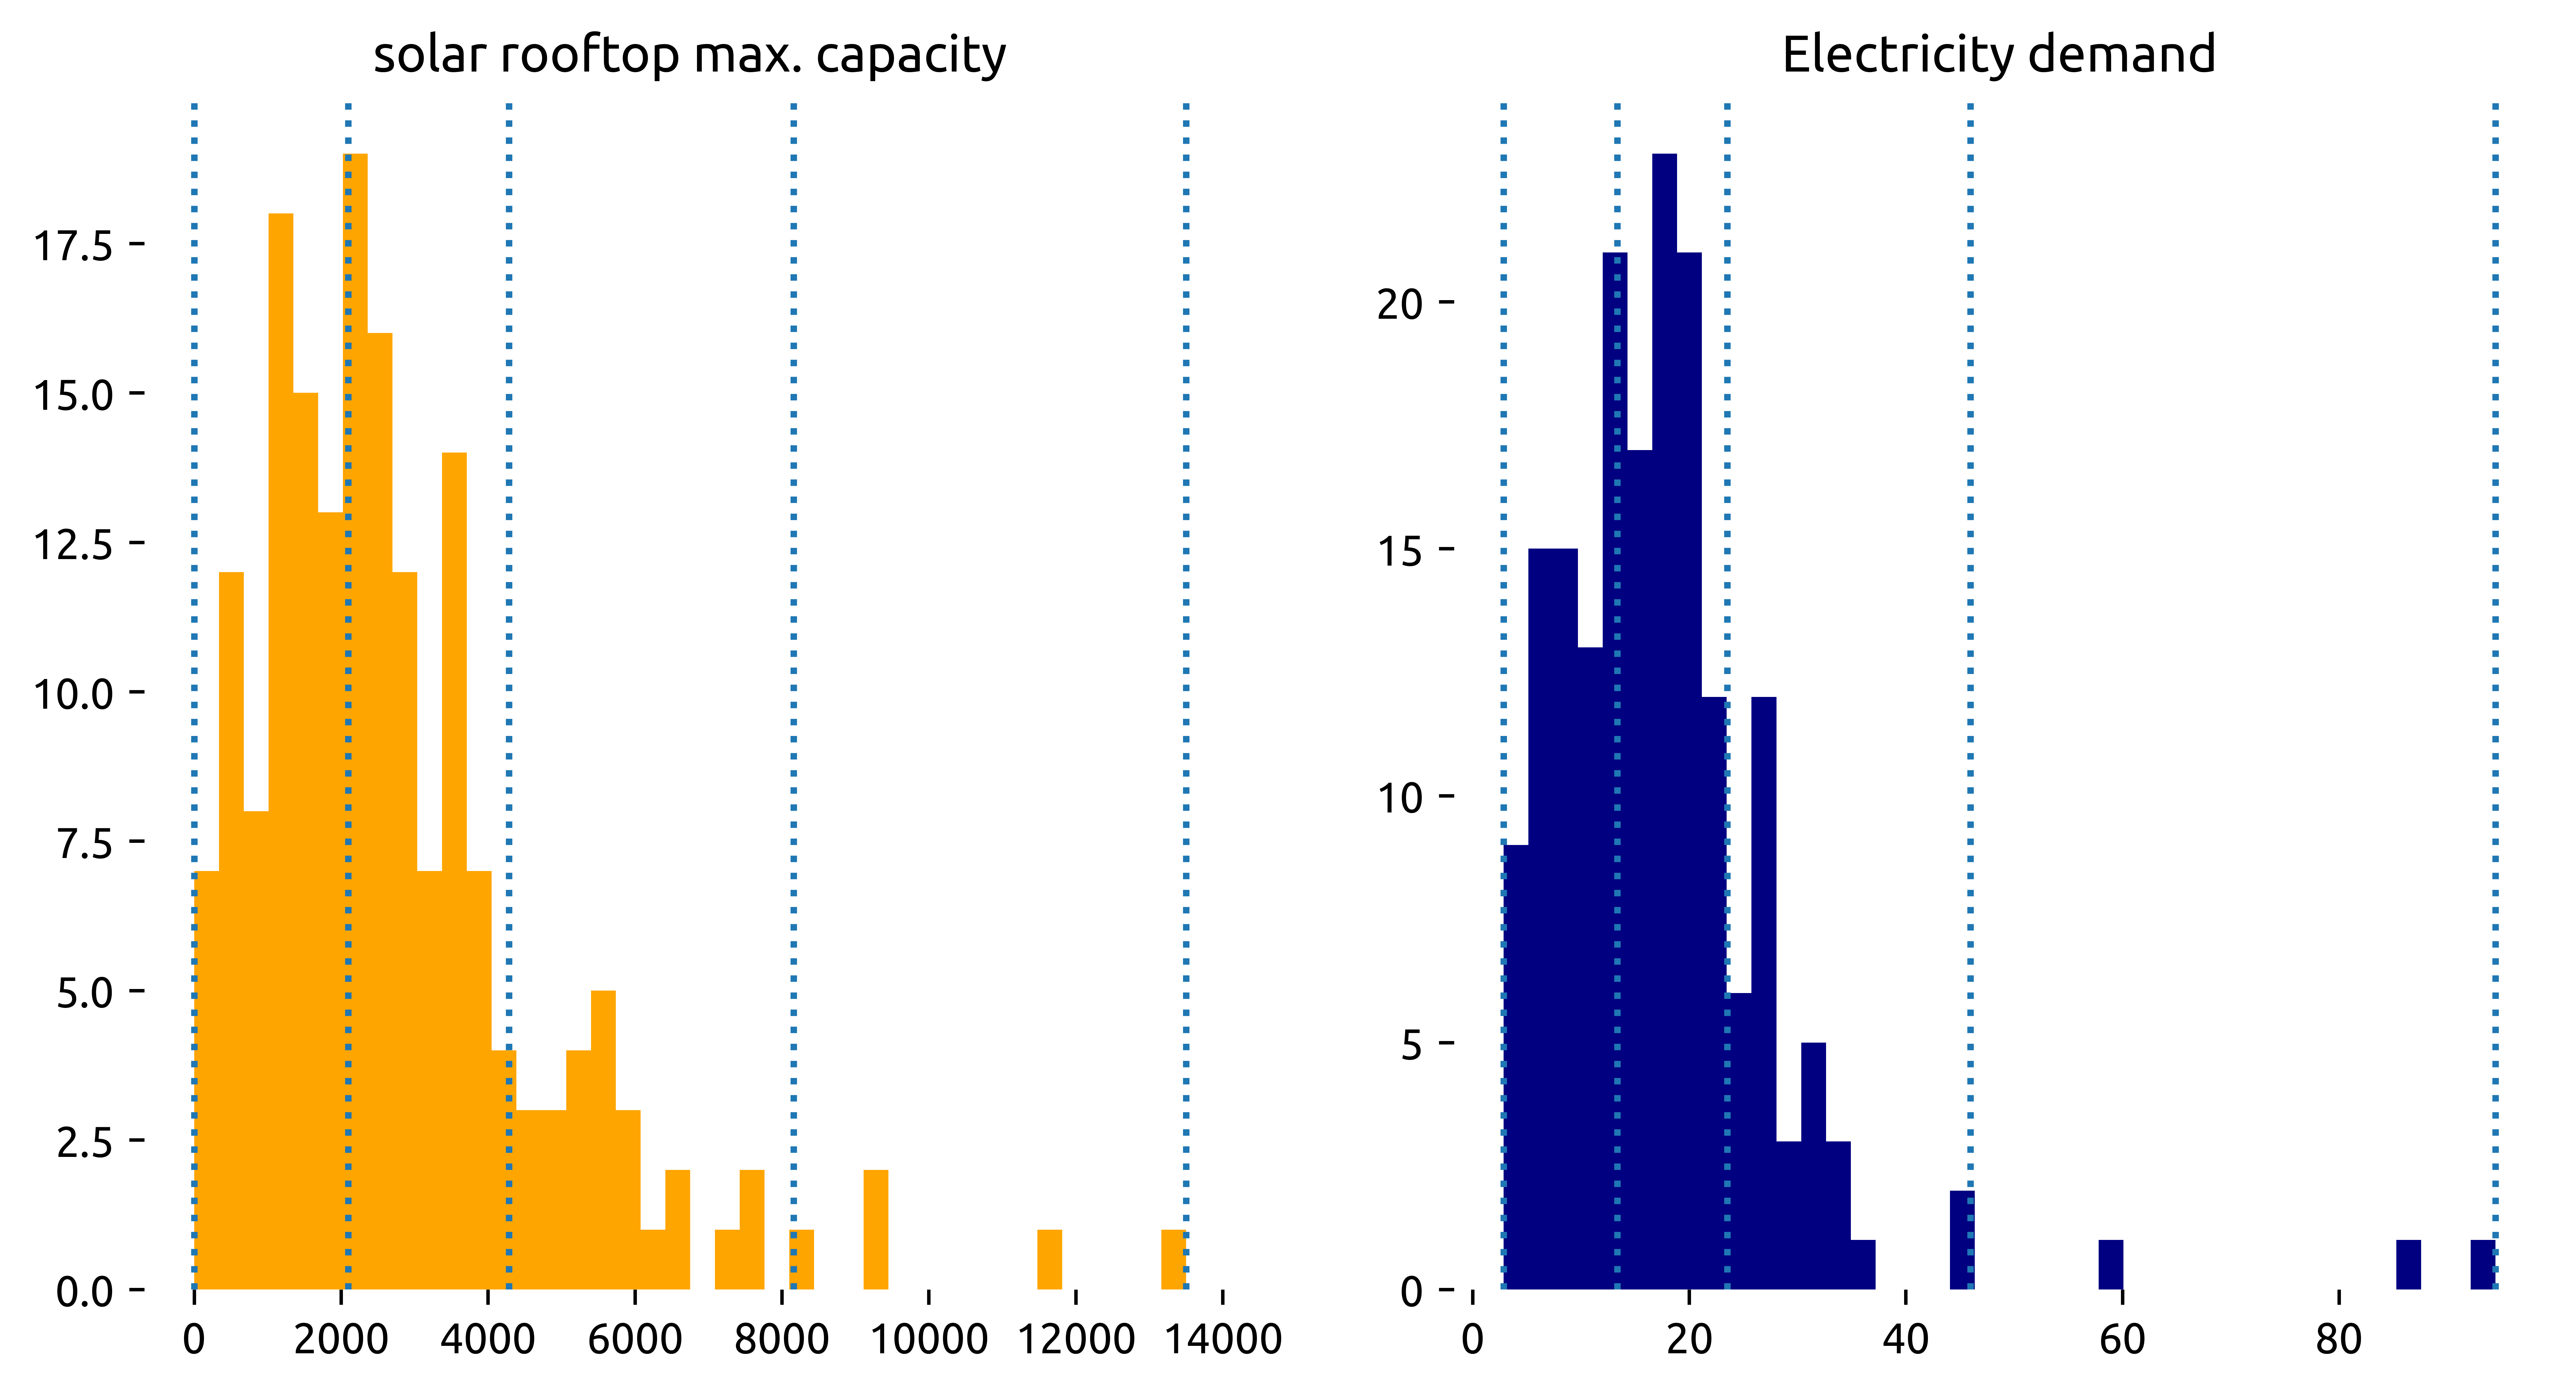

In [14]:
#The jenkspy method (k-means for 1D data): https://pbpython.com/natural-breaks.html
#finds natural breakes in data for binning : this method
#works best for our data here
fig, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].hist(s,density=False, bins=40, color='orange')
axs[0].set_title('solar rooftop max. capacity')
quants = jenkspy.jenks_breaks(s, n_classes=4)
for i in quants:
    axs[0].axvline(i, ymax = 1, linestyle = ":")

axs[1].hist(dem,density=False, bins=40, color='navy')
quants = jenkspy.jenks_breaks(dem, n_classes=4)
for i in quants:
    axs[1].axvline(i, ymax = 1, linestyle = ":")
axs[1].set_title('Electricity demand')

plt.show()

In [14]:
import matplotlib as mpl

def mix_colors_rgba(color_a, color_b, mode="mix", t=None, gamma=2.2):
    """
    Mix two colors color_a and color_b.

    Arguments:
        color_a:    Real-valued 4-tuple. Foreground color in "blend" mode.
        color_b:    Real-valued 4-tuple. Background color in "blend" mode.
        mode:       "mix":   Interpolate between two colors.
                    "blend": Blend two translucent colors.
        t:          Mixing threshold.
        gamma:      Parameter to control the gamma correction.

    Returns: 
        rgba:       A 4-tuple with the result color.

    To reproduce Markus Jarderot's solution:
            mix_colors_rgba(a, b, mode="blend", t=0, gamma=1.)
    To reproduce Fordi's solution:
            mix_colors_rgba(a, b, mode="mix", t=t, gamma=2.)
    To compute the RGB color of a translucent color on white background:
            mix_colors_rgba(a, [1,1,1,1], mode="blend", t=0, gamma=None)
    """
    assert(mode in ("mix", "blend"))
    assert(gamma is None or gamma>0)
    t = t if t is not None else (0.5 if mode=="mix" else 0.)
    t = max(0,min(t,1))
    color_a = np.asarray(color_a)
    color_b = np.asarray(color_b)
    if mode=="mix" and gamma in (1., None):
        r, g, b, a = (1-t)*color_a + t*color_b
    elif mode=="mix" and gamma > 0:
        r,g,b,_ = np.power((1-t)*color_a**gamma + t*color_b**gamma, 1/gamma)
        a = (1-t)*color_a[-1] + t*color_b[-1]
    elif mode=="blend":
        alpha_a = color_a[-1]*(1-t)
        a = 1 - (1-alpha_a) * (1-color_b[-1])
        s = color_b[-1]*(1-alpha_a)/a
        if gamma in (1., None):
            r, g, b, _ = (1-s)*color_a + s*color_b
        elif gamma > 0:
            r, g, b, _ = np.power((1-s)*color_a**gamma + s*color_b**gamma,
                                  1/gamma)

    return tuple(np.clip([r,g,b,a], 0, 1))

def mix_colors_rgb(color_a, color_b, mode="mix", t=None, gamma=2.2):
    """
    Mix two colors color_a and color_b.

    Arguments:
        color_a:    Real-valued 4-tuple. Foreground color in "blend" mode.
        color_b:    Real-valued 4-tuple. Background color in "blend" mode.
        mode:       "mix":   Interpolate between two colors.
                    "blend": Blend two translucent colors.
        t:          Mixing threshold.
        gamma:      Parameter to control the gamma correction.

    Returns: 
        rgba:       A 4-tuple with the result color.

    To reproduce Markus Jarderot's solution:
            mix_colors_rgba(a, b, mode="blend", t=0, gamma=1.)
    To reproduce Fordi's solution:
            mix_colors_rgba(a, b, mode="mix", t=t, gamma=2.)
    To compute the RGB color of a translucent color on white background:
            mix_colors_rgba(a, [1,1,1,1], mode="blend", t=0, gamma=None)
    """
    assert(mode in ("mix", "blend"))
    assert(gamma is None or gamma>0)
    t = t if t is not None else (0.5 if mode=="mix" else 0.)
    t = max(0,min(t,1))
    color_a = np.asarray(color_a)
    color_b = np.asarray(color_b)
    if mode=="mix" and gamma in (1., None):
        r, g, b = (1-t)*color_a + t*color_b
    elif mode=="mix" and gamma > 0:
        r,g,b,_ = np.power((1-t)*color_a**gamma + t*color_b**gamma, 1/gamma)
        a = (1-t)*color_a[-1] + t*color_b[-1]
    elif mode=="blend":
        alpha_a = color_a[-1]*(1-t)
        a = 1 - (1-alpha_a) * (1-color_b[-1])
        s = color_b[-1]*(1-alpha_a)/a
        if gamma in (1., None):
            r, g, b, _ = (1-s)*color_a + s*color_b
        elif gamma > 0:
            r, g, b, _ = np.power((1-s)*color_a**gamma + s*color_b**gamma,
                                  1/gamma)

    return tuple(np.clip([r,g,b], 0, 1))



def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [15]:

n=4
cmap1=truncate_colormap('Reds', 0,1) 
cmap2=truncate_colormap('bwr_r', 0.5, 1) 
X=np.tile(np.arange(n), [int(n*1),1])/10
Y=np.flip(((np.tile(np.arange(n), [int(n*1),1])/10).transpose()),axis=0)


arr_color = np.zeros((n,n,3))  
for i in range(n):
    for j in range (n):
        #print(i , j ,X[i][j]*(10/n), Y[i][j]*(10/n))
        arr_color[i][j]=mix_colors_rgba(cmap1(X[i][j]*(10/(n-1))), cmap2(Y[i][j]*(10/(n-1))), t=0.5, mode="blend", gamma=2.2)[:3]
          

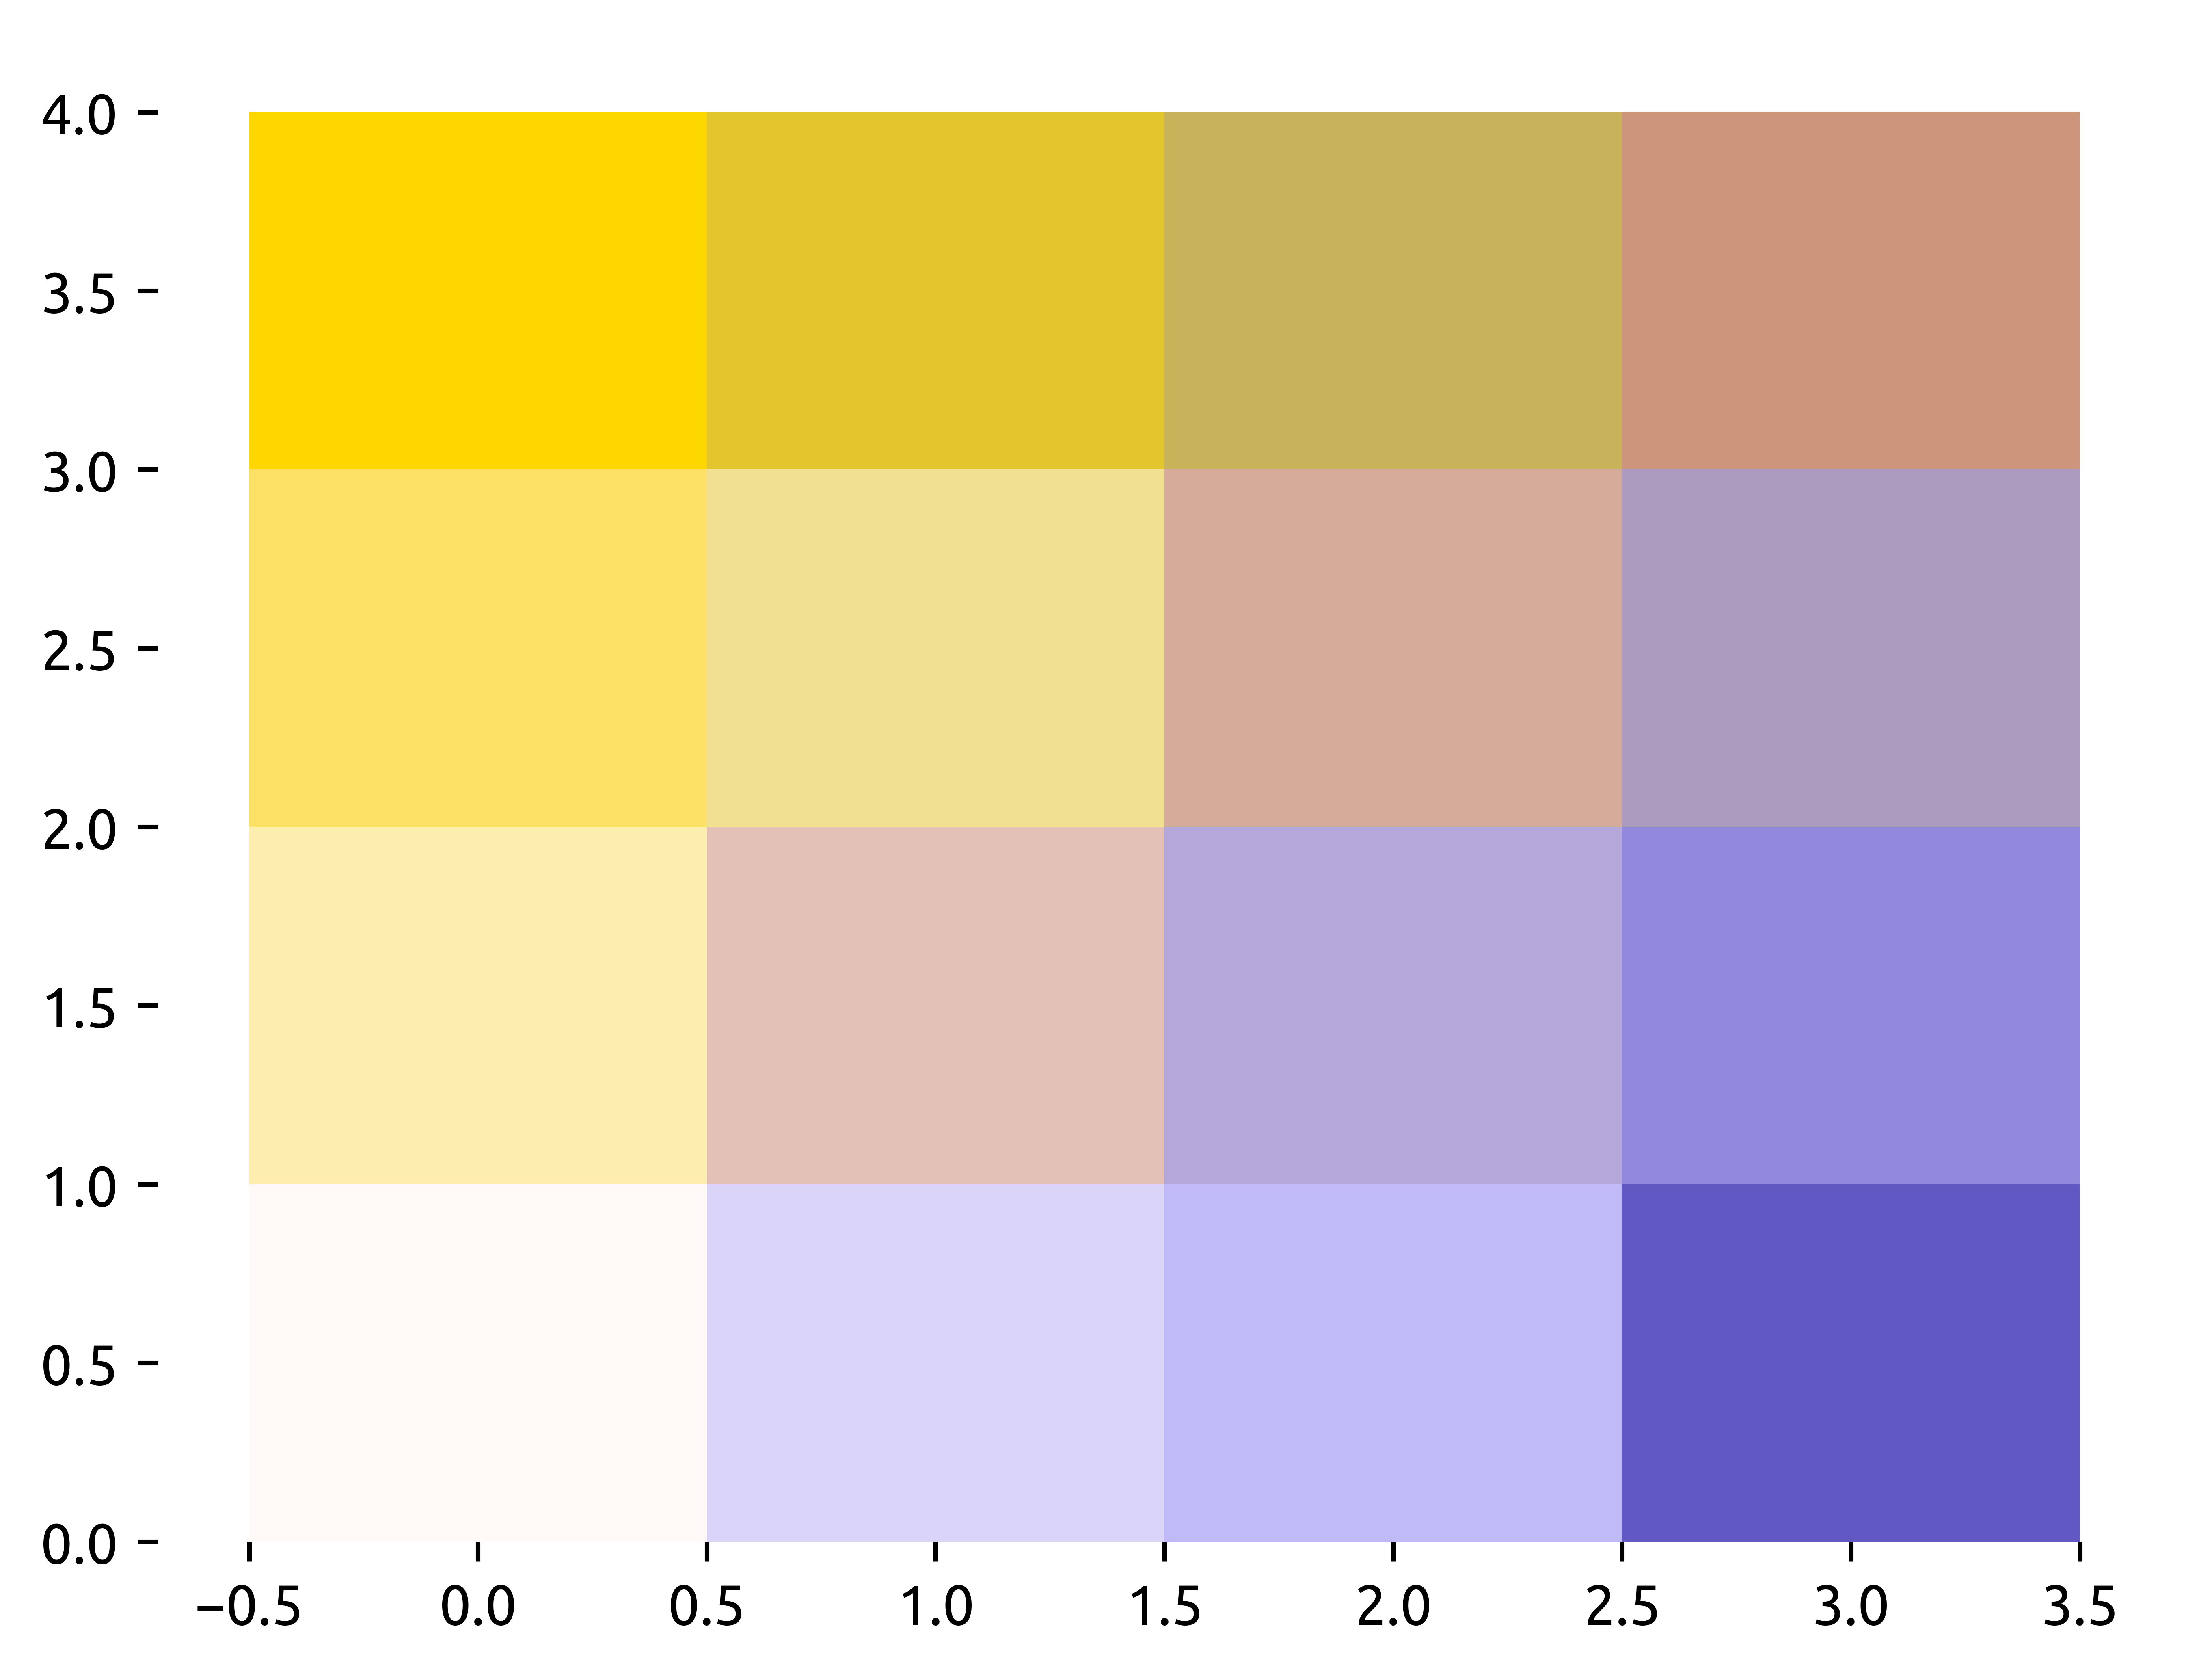

In [16]:
from matplotlib import colors
import copy

n=4
new_arr_color=copy.deepcopy(arr_color)

new_arr_color[0][0]=arr_color[3][0]
new_arr_color[0][2]=colors.to_rgba('#fce166')[:3]#colors.to_rgba('#fbdd7e')[:3]  ##goldenrod
new_arr_color[0][3]=colors.to_rgba('gold')[:3] #colors.to_rgba('#fec615')[:3]
new_arr_color[1][0]=arr_color[2][0]
new_arr_color[1][1]=mix_colors_rgb(colors.to_rgba('#c8ada0')[:3], new_arr_color[3][1], mode='mix', gamma=None)[:3]
new_arr_color[1][3]=mix_colors_rgb(new_arr_color[0][3], colors.to_rgba('#c8b35a')[:3], mode='mix', gamma=None)[:3] #
new_arr_color[1][2]=mix_colors_rgb(new_arr_color[1][3], new_arr_color[3][0], mode='mix', gamma=None)[:3]# colors.to_rgba('gold')[:3] #colors.to_rgba('#fffcc4')[:3]
new_arr_color[0][1]=mix_colors_rgb(new_arr_color[0][2], arr_color[3][0], mode='mix', gamma=None)[:3]# colors.to_rgba('gold')[:3] #colors.to_rgba('#fffcc4')[:3]

new_arr_color[2][0]=arr_color[1][0]
new_arr_color[2][1]=mix_colors_rgb(arr_color[2][3], arr_color[2][0], mode='mix', gamma=None)[:3]
new_arr_color[2][3]=colors.to_rgba('#c8b35a')[:3]
new_arr_color[3][0]=colors.to_rgba('#6258c4')[:3]
new_arr_color[3][1]=mix_colors_rgb(colors.to_rgba('#6258c4')[:3], arr_color[1][0], mode='mix', gamma=None)[:3]#colors.to_rgba('#6258c4')[:3]# colors.to_rgba('#464196')[0:3]
new_arr_color[3][2]=mix_colors_rgb(colors.to_rgba('#c8ada0')[:3], new_arr_color[3][1], mode='mix', gamma=None)[:3]
new_arr_color[3][3]=mix_colors_rgb(colors.to_rgba('#9a3001')[:3], new_arr_color[0][0], mode='mix', gamma=None)[:3]

new_arr_color[2][2]=mix_colors_rgb(new_arr_color[3][3], new_arr_color[1][1], mode='mix', gamma=None)[:3]#colors.to_rgba('#c8ada0')[:3]  ##

for i in range(n):
    for j in range (n):
        plt.bar(i,1, width=1, bottom=j,color=new_arr_color[i][j])

In [23]:
import matplotlib
import math
import jenkspy

n_array=4
def get_gdf_seq_colormap (dem, s,method='default'):
 if method is 'std':
   geodf['dem_category']=pd.cut(dem, bins=4, labels=["0", "1", "2", "3"])
   geodf['s_category']=pd.cut(s, bins=4, labels=["0", "1", "2", "3"])
   geodf['test']= lambda x,y: np.stack((1-x,0.76*np.ones_like(x),1-y), axis=2)
   geodf['seq_color']= lambda x,y: np.stack((1-x,0.76*np.ones_like(x),1-y), axis=2)
   for i in geodf.index:
     ii= int(geodf['dem_category'][i])
     jj= int(geodf['s_category'][i] )       
     geodf['test'][i]=(ii,jj)
     geodf['seq_color'][i]=(new_arr_color[ii][jj]) 
 if method is 'quantile':
   geodf['dem_category']=pd.qcut(dem, 4, labels=["0", "1", "2", "3"])
   geodf['s_category']=pd.qcut(s, 4, labels=["0", "1", "2", "3"])
   #geodf['test']= lambda x,y: np.stack((1-x,0.76*np.ones_like(x),1-y), axis=2)
   #geodf['seq_color']= lambda x,y: np.stack((1-x,0.76*np.ones_like(x),1-y), axis=2)
   for i in geodf.index:
     ii= int(geodf['dem_category'][i])
     jj= int(geodf['s_category'][i] )       
     geodf['test'][i]=(ii,jj)
     geodf['seq_color'][i]=(new_arr_color[ii][jj]) 
 if method is 'kmeans':
   breaks = jenkspy.jenks_breaks(dem, n_classes=4) 
   geodf['dem_category']=pd.cut(dem,  bins=breaks, labels=["0", "1", "2", "3"], include_lowest=True)
   #geodf['dem_category']= geodf['dem_category'].fillna(0)    #issue with jenskpy method
   breaks = jenkspy.jenks_breaks(s, n_classes=4) 
   geodf['s_category']=pd.cut(s,  bins=breaks, labels=["0", "1", "2", "3"], include_lowest=True)
   #geodf['s_category']= geodf['s_category'].fillna(0)    #issue with jenskpy method
   geodf['test']= lambda x,y: np.stack((1-x,0.76*np.ones_like(x),1-y), axis=2)
   geodf['seq_color']= lambda x,y: np.stack((1-x,0.76*np.ones_like(x),1-y), axis=2)
   for i in geodf.index:
     ii= int(geodf['dem_category'][i])
     jj= int(geodf['s_category'][i] )       
     geodf['test'][i]=(ii,jj)
     geodf['seq_color'][i]=(new_arr_color[ii][jj])    

 return geodf['seq_color']

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_18261/2978392322.py:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'std':
/tmp/ipykernel_18261/2978392322.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'quantile':
/tmp/ipykernel_18261/2978392322.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'kmeans':


/tmp/ipykernel_18261/2978392322.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geodf['test'][i]=(ii,jj)
/tmp/ipykernel_18261/2978392322.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geodf['seq_color'][i]=(new_arr_color[ii][jj])
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/parisr/miniconda3/envs/pypsa-eur2/lib/python

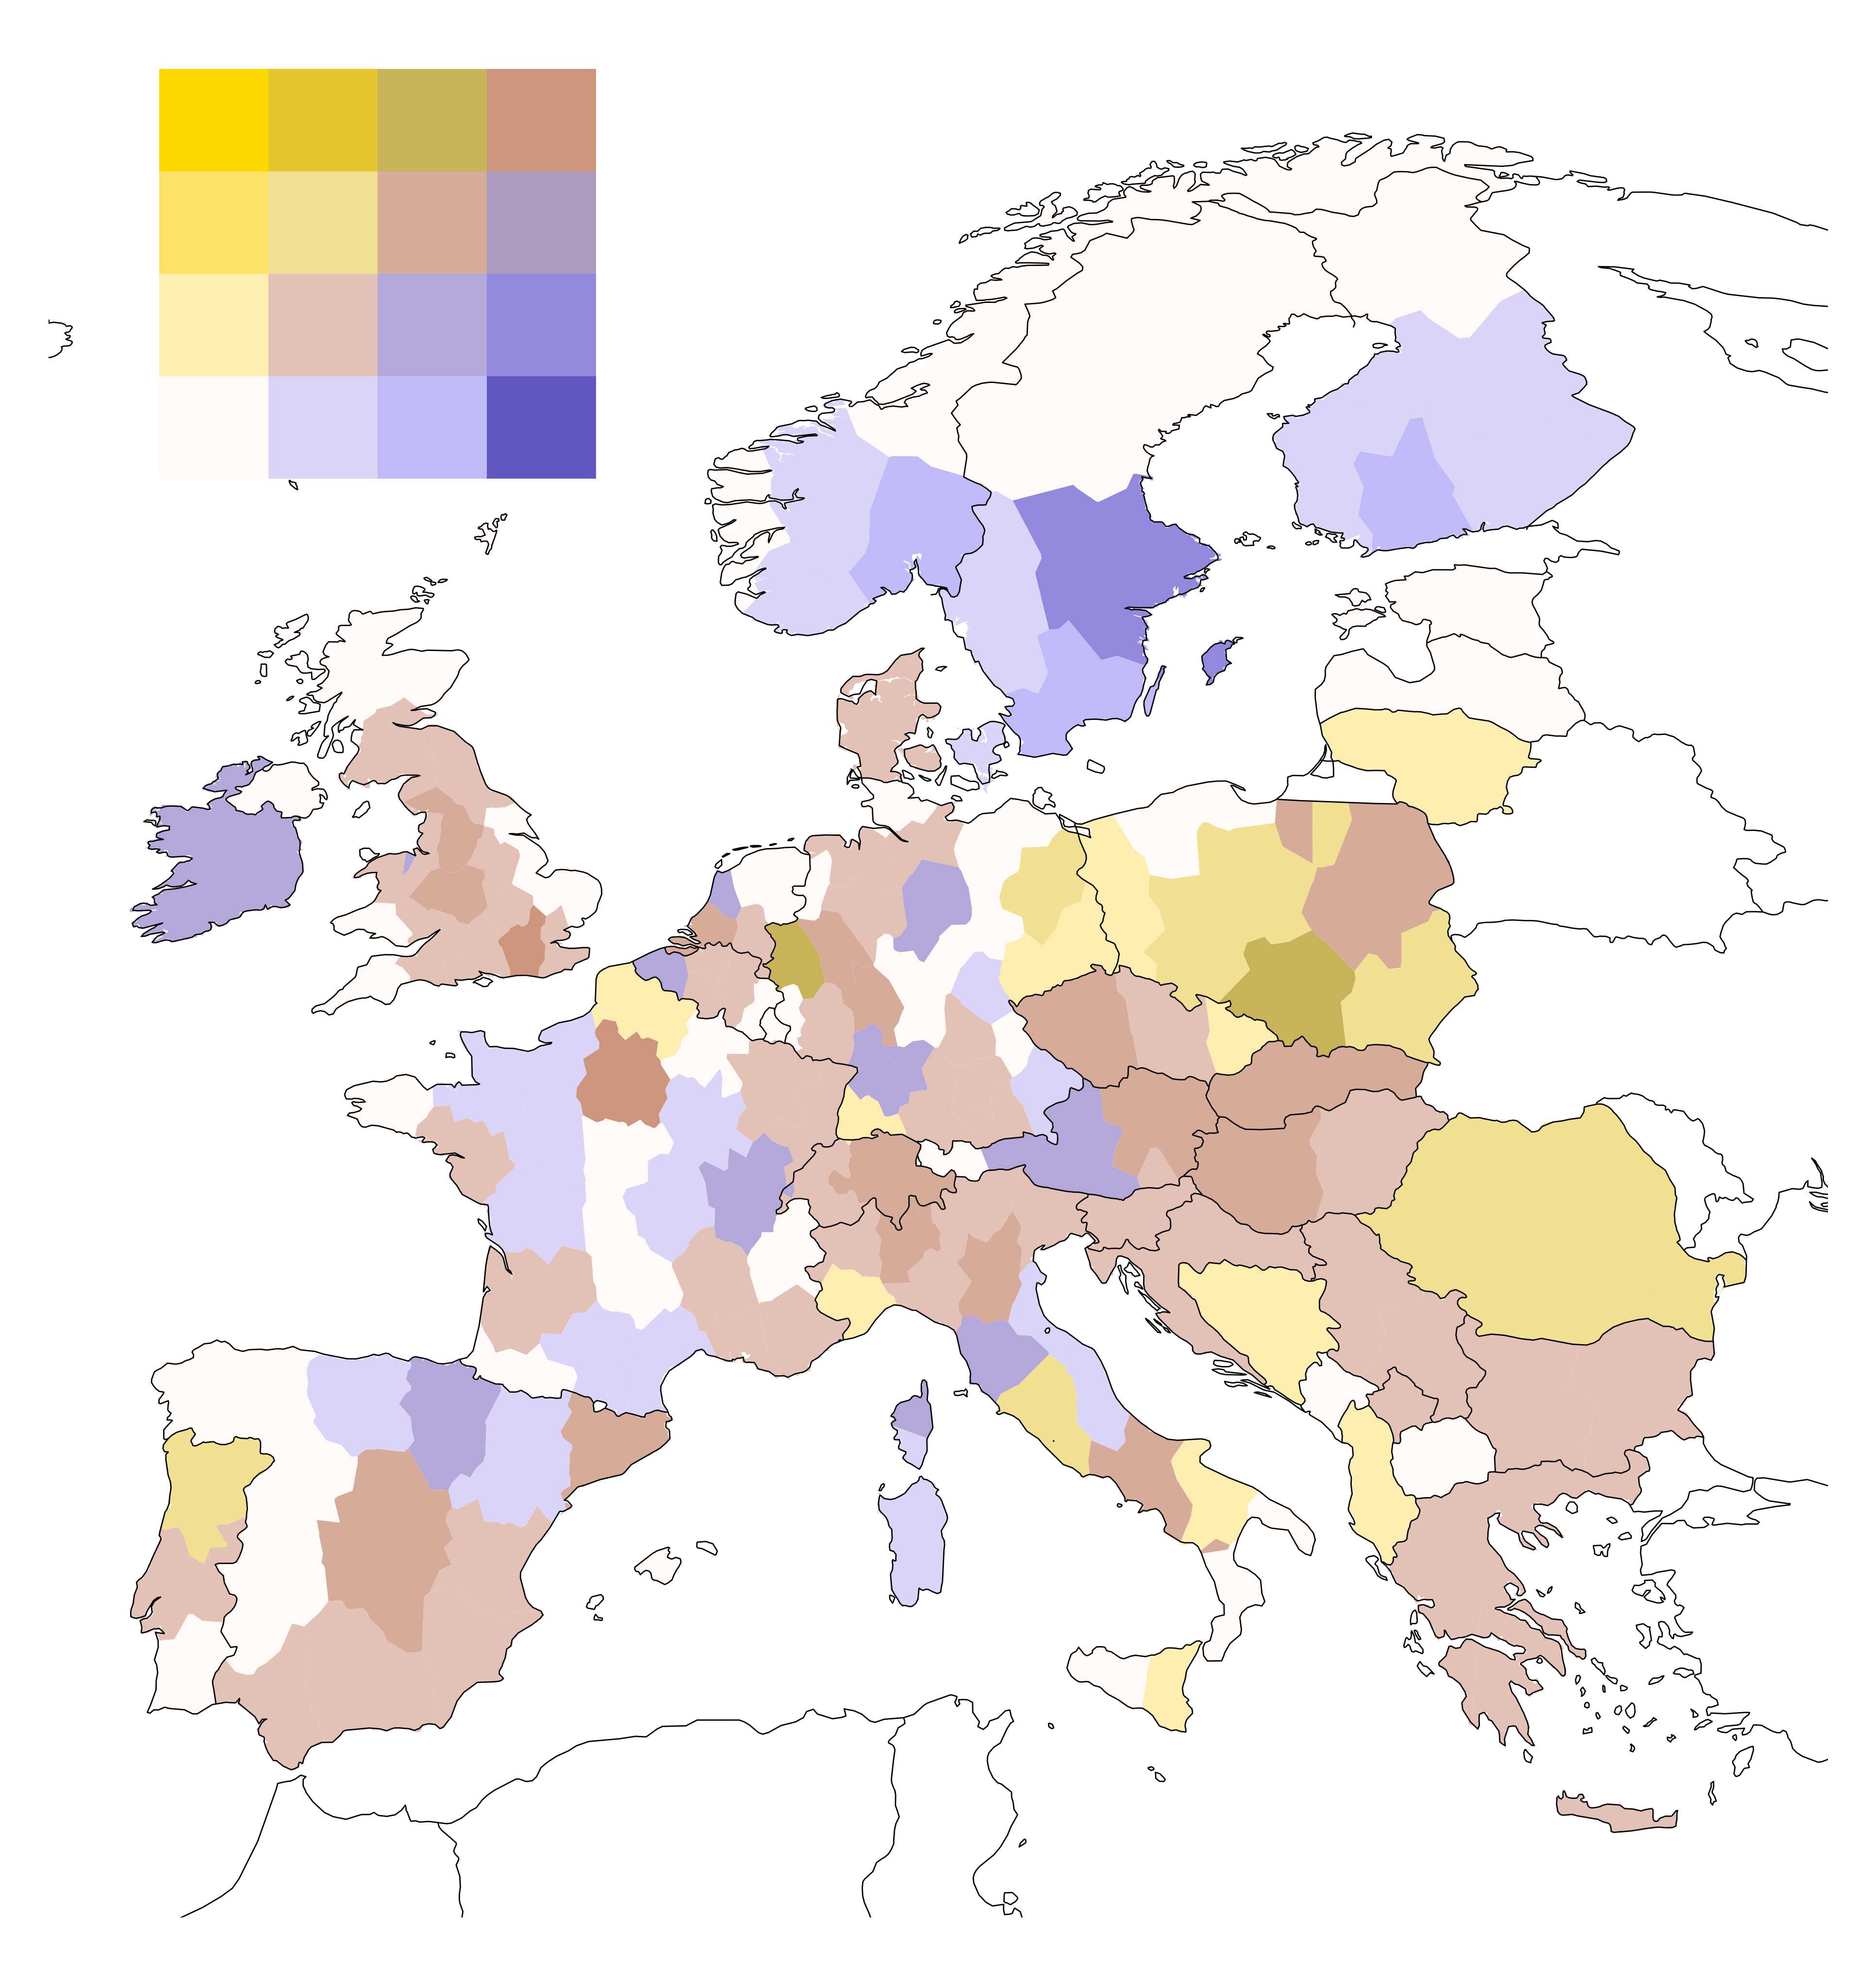

In [25]:
fig, axs = plt.subplots( figsize=(5, 5), subplot_kw={"projection": proj})
plt.rcParams['figure.dpi'] = 1000
dem=demand_by_region.filter(regex=regex['electricity']).sum(axis=1)

geodf.plot(
        ax=axs,
        color=get_gdf_seq_colormap(dem, s, 'kmeans'),
        # transform=ccrs.PlateCarree(),
        alpha=1,
        linewidths=0,
        legend=True,
        legend_kwds={"label": 'PV-demand corelation', "shrink": 0.7, "extend": "max"},
    )

axs.add_feature(cartopy.feature.COASTLINE.with_scale("50m"), linewidth=0.2, zorder=2)
axs.add_feature(cartopy.feature.BORDERS.with_scale("50m"), linewidth=0.2, zorder=2)

axins = axs.inset_axes([0.05, 0.77, 0.27, 0.23])

for i in range(4):
    for j in range (4):
        axins.bar(i,1, width=1, bottom=j,color=new_arr_color[i][j])
axins.set_xticks([], [])
axins.set_yticks([], [])
plt.show()